Reference: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains an autoencoder with the instances of normal ECGs in the training data. Then, it measures the reconstruction loss for both the normal and abnormal ECGs in the test data. The reconstruction loss for the instances of the abnormal ECGs in the test data is higher. A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution). Then, if the reconstruction loss of a normal ECG in the training data is higher than this threshold, it is classified as abnormal. By comparing with the known labels of test data (with T for normal ECG(s) and F for abnormal ECG(s)), the confusion matrix and the accuracy is calculated.

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model

Loading the ECG5000 data

In [137]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Parse the data so it can be split creating a variable containing the labels and another containing the data. Splitting the data into train, validation, and test set.

In [138]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

train_data, valid_data, train_labels, valid_labels = train_test_split(
    train_data, train_labels, test_size=.1, random_state=21
)

Normalize the data so the features are treated equally, normalizing using the overall min and max value of all training data (train/validation set).

In [139]:
min_val = tf.reduce_min(tf.concat([train_data, valid_data], 0))
max_val = tf.reduce_max(tf.concat([train_data, valid_data], 0))

train_data = (train_data - min_val) / (max_val - min_val)
valid_data = (valid_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

The autoencoder is trained using only the normal rhythms, which are labeled in this dataset as 1. Here the normal rhythms is separated from the abnormal rhythms, and the labels are casted as type bool.

In [140]:
train_labels = train_labels.astype(bool)
valid_labels = valid_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_valid_data = valid_data[valid_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_valid_data = valid_data[~valid_labels]
anomalous_test_data = test_data[~test_labels]

Plotting a normal ECG from the training set 

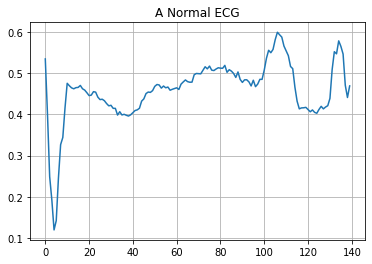

In [141]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plotting an anomalous ECG.

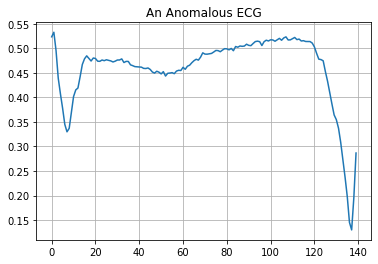

In [142]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Building the Anomaly Detection Model, the encoder architecture is $140→ 32 → 16 → 8$. Thus, the decoder is the same architecture but in the opposite direction:

In [143]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="selu"),
      layers.Dense(16, activation="selu"),
      layers.Dense(8, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="selu"),
      layers.Dense(32, activation="selu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Compiling the model using Adam optimizer and Mean Squared Error as the loss function:

In [144]:
autoencoder.compile(optimizer='adam', loss='mae')

Creating a callback to monitor validation loss to prevent overfitting of the model if the validation loss doesn't go down in 10 epochs, training is stopped.

In [145]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

Note we train the Autoencoder only on the normal ECG training set but both the normal and abnormal data is contained in the test set.

In [146]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
            epochs=100, 
            batch_size=128,
            callbacks = [callback],
            validation_data=(normal_valid_data, normal_valid_data),
            shuffle=True)

Epoch 1/100
17/17 [==============================] - 1s 15ms/step - loss: 0.0713 - val_loss: 0.0529
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0449 - val_loss: 0.0370
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0319 - val_loss: 0.0285
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0266 - val_loss: 0.0254
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0239 - val_loss: 0.0234
Epoch 6/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0221 - val_loss: 0.0218
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 8/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0201 - val_loss: 0.0207
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0203
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0197
Epoch 11

Plotting the training and validation loss for each epoch of training:

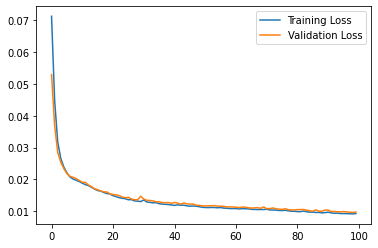

In [147]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plotting a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

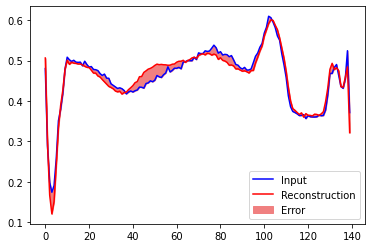

In [148]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Now, we will do the same for the anomalous data:

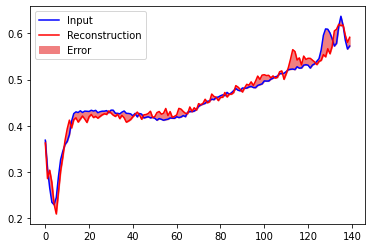

In [149]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Here will compute the normal/abnormal train/validation loss from the model using mean absolute error.

In [150]:
# Normal reconstructions
reconstructions_train = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data)
reconstructions_valid = autoencoder.predict(normal_valid_data)
valid_loss = tf.keras.losses.mae(reconstructions_valid, normal_valid_data)
# Abnormal reconstructions
ab_reconstructions_train = autoencoder.predict(anomalous_train_data)
ab_train_loss = tf.keras.losses.mae(ab_reconstructions_train, anomalous_train_data)
ab_reconstructions_valid = autoencoder.predict(anomalous_valid_data)
ab_valid_loss = tf.keras.losses.mae(ab_reconstructions_valid, anomalous_valid_data)

Defining a function predict which takes the model, data, and threshold. Computes the reconstruction loss and returns the truthy value for all elements if they are less than the threshold (True).

In [151]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

Computing the abnormal/normal mean of the validation loss

In [152]:
abnormal_valid_mean_loss = np.mean(ab_valid_loss)
normal_valid_mean_loss = np.mean(valid_loss)

Computing 100 different thresholds that start at the normal threshold and end at the abnormal threshold incrementing by their difference divided by 100.

In [153]:
increment = (abnormal_valid_mean_loss - normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, 
increment)

Creating a numpy array to store the accuracy for each of the different threshold values.

In [154]:
thresh_size = thresholds.shape[0]
accuracies = np.zeros(thresh_size)

Calculation of the threshold that gives the best accuracy on the validation data. This is done by going through all thresholds and testing the accuracy of the model with each threshold.


In [155]:
for i in range(thresh_size):
  preds = predict(autoencoder, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels)

Setting the threshold to the one in thresholds which gave the best accuracy.

In [156]:
argmax = np.argmax(accuracies)
best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", best_threshold)

The best threshold based on validation data:  0.019116752222180334


We now detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold we just computed. We then will classify future examples as anomalous if the reconstruction error is higher than this threshold.

Plotting the reconstruction error on all ECGs from the training set

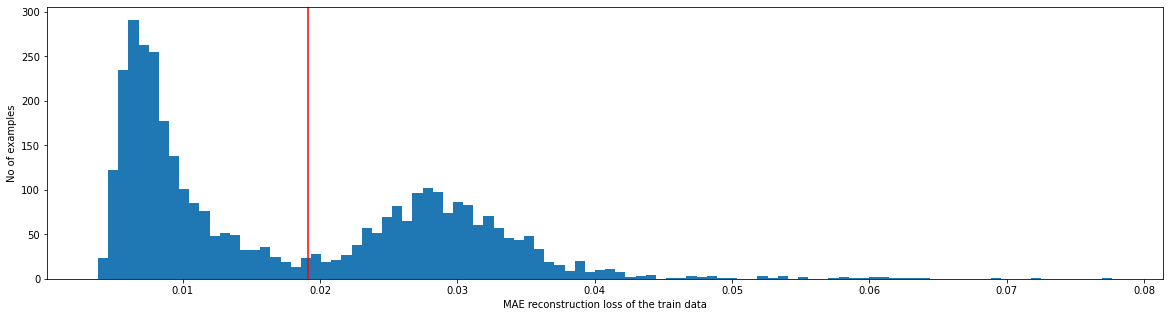

In [157]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)
plt.figure(figsize=(20,5))
plt.hist(train_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the train data")
plt.ylabel("No of examples")
plt.show()

Plotting the reconstruction error on all ECGs from the validation set

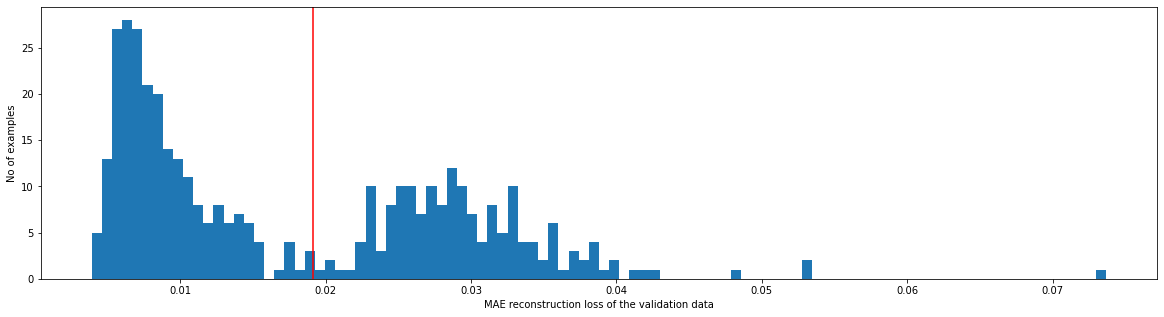

In [158]:
reconstructions = autoencoder.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions, valid_data)
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

Plotting the reconstruction error on all ECGs from the test set

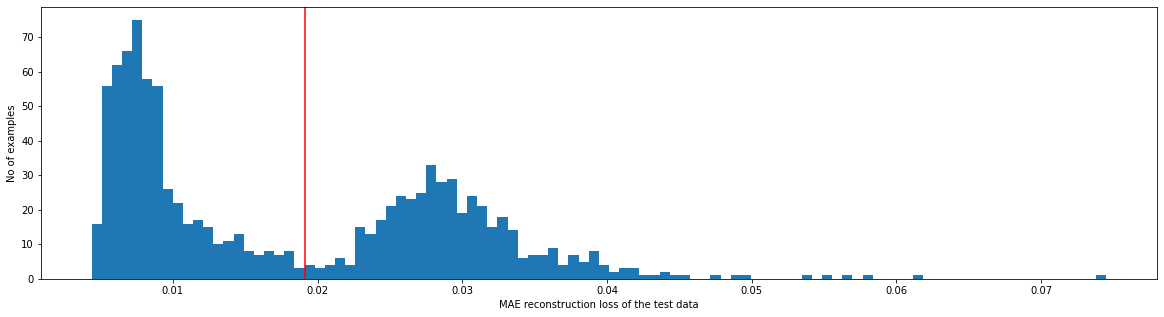

In [159]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
plt.figure(figsize=(20,5))
plt.hist(test_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [160]:
def print_stats(predictions, labels, model, data):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], labels[labels == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], labels[labels == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  reconstructions = model.predict(data[labels])
  nl_test_loss =  tf.keras.losses.mae(reconstructions, data[labels])
  print("Normal Test Data Mean = {}".format(np.mean(nl_test_loss)))
  print("Normal Test Data Standard Deviation = {}".format(np.std(nl_test_loss)))
  reconstructions = model.predict(data[~labels])
  ab_test_loss =  tf.keras.losses.mae(reconstructions, data[~labels])
  print("Abnormal Test Data Mean = {}".format(np.mean(ab_test_loss)))
  print("Abnormal Test Data Standard Deviation = {}".format(np.std(ab_test_loss)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [161]:
thr_acc = np.zeros((thresh_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax - 2 : argmax + 3]

array([[0.01871858, 0.9475    ],
       [0.01891766, 0.9475    ],
       [0.01911675, 0.95      ],
       [0.01931584, 0.95      ],
       [0.01951493, 0.95      ]])

Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data

In [162]:
preds = predict(autoencoder, test_data, best_threshold)
print_stats(preds, test_labels, autoencoder, test_data)

Confusion Matrix: 
 prediction: F      T 
             440   560
 label: F   [[420   20]    440
        T    [20   540]]   560
Accuracy = 0.96
Normal Test Data Mean = 0.009169315919280052
Normal Test Data Standard Deviation = 0.004234729800373316
Abnormal Test Data Mean = 0.029635341838002205
Abnormal Test Data Standard Deviation = 0.006848580669611692
Precision = 0.9642857142857143
Recall = 0.9642857142857143


In [163]:
accuracy = (0.975 + .979 + 0.978 + 0.974 + 0.976 + 0.975 + 0.979 + 0.965 + 0.978 + 0.965)/10.

In [34]:
round(accuracy, 4)

0.9744

In [35]:
precision = (0.9890310786106032 + 0.9908925318761385 + 0.9890909090909091 + 0.9854545454545455 + 0.9872727272727273 + 0.9837251356238698 + 0.9908925318761385 + 0.987012987012987 + 0.9890909090909091 + 0.9597197898423818)/10.

In [37]:
round(precision, 4)

0.9852

In [38]:
recall = (0.9660714285714286 + 0.9714285714285714 + 0.9714285714285714 + 0.9678571428571429 + 0.9696428571428571 + 0.9714285714285714 + 0.9714285714285714 + 0.95 + 0.9714285714285714 + 0.9785714285714285)/10.

In [39]:
round(recall, 4)

0.9689